# Dfsu - 3D sigma-z
This notebook demonstrates, reading from a sigma-z dfsu file, top- and bottom elements, extracting a profile, save selected layers to new dfsu file and save to mesh. 

It also shows how to read a sigma-z vertical slice file. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mikeio import Dfsu, Mesh

In [2]:
filename = "../tests/testdata/oresund_sigma_z.dfsu"
dfs = Dfsu(filename)
dfs

Dfsu3DSigmaZ
Number of elements: 17118
Number of nodes: 12042
Projection: UTM-33
Number of sigma layers: 4
Max number of z layers: 5
Items:
  0:  Z coordinate <ItemGeometry3D> (meter)
  1:  Temperature <Temperature> (degree Celsius)
  2:  Salinity <Salinity> (PSU)
Time: 3 steps with dt=10800.0s
      1997-09-15 21:00:00 -- 1997-09-16 03:00:00

In [3]:
elem_ids = dfs.bottom_elements
print(elem_ids[:10])
print(dfs.top_elements[:10])
print(len(dfs.bottom_elements))

[ 0  5  9 13 17 21 25 29 33 37]
[ 4  8 12 16 20 24 28 32 36 40]
3700


In [4]:
geom = dfs.elements_to_geometry(elem_ids, node_layers='bottom')
geom

Unstructured Geometry
Number of nodes: 2820
Number of elements: 3700
Number of layers: 6
Projection: UTM-33

In [5]:
ze = geom.element_coordinates[:,2]
ze.min()

-33.0

## Save bottom layer to new mesh file

In [6]:
outmesh = "mesh_oresund_extracted.mesh"
dfs.to_mesh(outmesh)

## Evaluate top layer

In [7]:
elem_ids = dfs.top_elements

In [8]:
ds = dfs.read(elements=elem_ids)
print(ds)
max_t = ds['Temperature'].max()
print(f'Maximum temperature in top layer: {max_t:.1f}')

<mikeio.DataSet>
Dimensions: (3, 3700)
Time: 1997-09-15 21:00:00 - 1997-09-16 03:00:00
Items:
  0:  Z coordinate <ItemGeometry3D> (meter)
  1:  Temperature <Temperature> (degree Celsius)
  2:  Salinity <Salinity> (PSU)
Maximum temperature in top layer: 17.5


## Find position of max temperature in first time step and plot

In [9]:
timestep = 0
max_elem = ds['Temperature'][timestep,:].argmax()
top_element_coordinates = dfs.element_coordinates[dfs.top_elements]
max_x = top_element_coordinates[max_elem][0]
max_y = top_element_coordinates[max_elem][1]
max_x, max_y

(333934.085102392, 6158101.508170851)

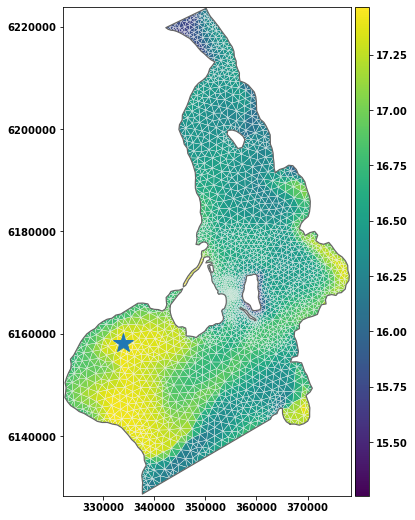

In [10]:
ax = dfs.plot(z=ds['Temperature'][timestep,:], figsize=(6,7), label="Temperature")
ax.plot(max_x, max_y, marker='*', markersize=20);

# Assess profile
Find water column which has highest temperature and plot profile for all 3 time steps

In [11]:
elem_ids = dfs.find_nearest_profile_elements(max_x, max_y)
z_profile = dfs.element_coordinates[elem_ids,2]

In [12]:
ds_profile = dfs.read(items=['Temperature'], elements=elem_ids)

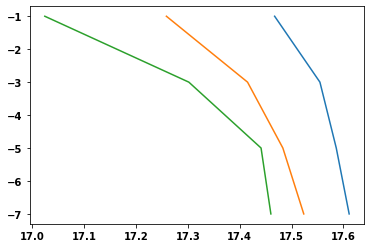

In [13]:
for timestep in range(len(ds_profile.time)):
    plt.plot(ds_profile[0][timestep, :],z_profile)

In [14]:
bot_elem_id = dfs.find_nearest_element(max_x, max_y, -7)
bot_elem_id

5320

In [15]:
dfs.read(items=['Temperature'], elements=[bot_elem_id]).data[0]

array([[17.61092186],
       [17.52342224],
       [17.46005821]])

# Select top elements of a smaller area

In [16]:
eid = dfs.top_elements
xc = dfs.element_coordinates[eid,0]
yc = dfs.element_coordinates[eid,1]

In [17]:
mask = (yc>6192000)*(yc<6198000)
elem_ids = eid[mask]
len(elem_ids)

118

In [18]:
ds_sub = dfs.read(elements=elem_ids)
ds_sub

<mikeio.DataSet>
Dimensions: (3, 118)
Time: 1997-09-15 21:00:00 - 1997-09-16 03:00:00
Items:
  0:  Z coordinate <ItemGeometry3D> (meter)
  1:  Temperature <Temperature> (degree Celsius)
  2:  Salinity <Salinity> (PSU)

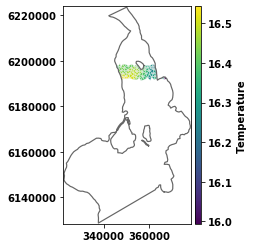

In [19]:
dfs.plot(z=ds_sub.data[1][0,:], elements=elem_ids, figsize=(6,7), label='Temperature')

In [20]:
dfs.write("oresund_data_extracted.dfsu", ds_sub, elements=elem_ids)

will redo extraction in 2d!


# Select top 2 layers and write to new file
get_layer_elements() can take a list of layers. Layers are counted positive from the bottom starting at 1 or alternatively counted negative from the top starting at 0. Here we take layers 0 and -1 which means the two top layers. 

Next data is read from source file and finally written to a new dfsu file (which is now sigma-only dfsu file).

In [21]:
elem_ids = dfs.get_layer_elements([-1, 0])

In [22]:
ds_top2 = dfs.read(elements=elem_ids)

In [23]:
outfile = "oresund_top2_layers.dfsu"
dfs.write(outfile, ds_top2, elements=elem_ids)

# Read vertical slice

In [24]:
filename = "../tests/testdata/oresund_vertical_slice.dfsu"
dfs = Dfsu(filename)
dfs

DfsuVerticalProfileSigmaZ
Number of elements: 441
Number of nodes: 550
Projection: UTM-33
Number of sigma layers: 4
Max number of z layers: 5
Items:
  0:  Z coordinate <ItemGeometry3D> (meter)
  1:  Temperature <Temperature> (degree Celsius)
  2:  Salinity <Salinity> (PSU)
Time: 3 steps with dt=10800.0s
      1997-09-15 21:00:00 -- 1997-09-16 03:00:00

In [25]:
print(dfs.bottom_elements[:9])
print(dfs.n_layers_per_column[:9])
print(dfs.top_elements[:9])

[ 0  5 10 15 20 24 28 32 36]
[5 5 5 5 4 4 4 4 4]
[ 4  9 14 19 23 27 31 35 39]


# Clean up

In [26]:
import os
os.remove("mesh_oresund_extracted.mesh")
os.remove("oresund_data_extracted.dfsu")
os.remove("oresund_top2_layers.dfsu")